# LSTM 2 Cluster KMeans Clustered Data(EN-DE) with Facebooks MUSE word embedding

The idea here is to divide the data into two clusters based on the results from K-Means clustering. Trainable true



In [0]:
# Imports
import os
import keras
import sys
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Bidirectional
from keras.layers import Embedding as emb
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn 

# Setting seed to get reproducable results
from numpy.random import seed
from tensorflow import set_random_seed
SEED = 13
seed(SEED)
set_random_seed(SEED)

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Getting English and German word embeddings
with open('/content/gdrive/My Drive/Thesis/fbMUSE/wiki.multi.en.vec') as e:
    en_vec = e.readlines()
with open('/content/gdrive/My Drive/Thesis/fbMUSE/wiki.multi.de.vec') as d:
    de_vec = d.readlines()

In [0]:
en_de= en_vec+de_vec

## Preparing Data
The word embedding created using facebooks MUSE are not preprocessed in anyway except fot lower case the words. So in order to use these word embedding we need the data into the same format. 

In [0]:
!unzip /content/gdrive/My\ Drive/Thesis/data/Scrapped_raw.zip 

Archive:  /content/gdrive/My Drive/Thesis/data/Scrapped_raw.zip
replace scrapped_data/agriculture/agriculture  enlargement/Cyprus.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
!python removeMajority_drive.py

The above command will create dataset for the training of facebooks word embeddings as the embeddings were trained on unprocessed data, I had to prepare that too. All though all the words need to be lower cased.

In [0]:
# unpickle data
import pickle
def unpickle(obj):
    with open(obj, 'rb') as picklehandle:
        toReturn = pickle.load(picklehandle)
    return toReturn

In [0]:
en_de_combined = unpickle('/content/combined_data.pkl')
label = unpickle('/content/en-de-label.pkl')
# en_data = unpickle('/content/EN-DATA.pkl')
# en_label = unpickle('/content/EN-LABEL.pkl')
# de_data = unpickle('/content/DE-DATA.pkl')
# de_label = unpickle('/content/DE-LABEL.pkl')

In [0]:
len(en_de_combined), len(label)

(2701, 2701)

In [0]:
# Initial Test Train Split
train_data, test_data, train_la, test_la = train_test_split(en_de_combined, label,test_size=0.3, random_state=13)

In [0]:
len(train_data)+ len(test_data)


2701

In [0]:
train_data[1].split('\n\n\n')

["Use of passenger records to prevent terrorism and serious crime Use of passenger records to prevent terrorism and serious crime SUMMARY OF: Directive (EU) 2016/681 on the use of passenger name record (PNR) data for the prevention, detection, investigation and prosecution of terrorist offences and serious crime WHAT IS THE AIM OF THE DIRECTIVE? It aims to regulate the transfer of the passenger name record (PNR) data of passengers on international flights from airlines to the European Union (EU) countries. It also regulates the processing of these data by EU countries competent authorities. KEY POINTS What are PNR data? They consist of booking information stored by airlines in their reservation and departure control systems. The information collected includes: travel dates; travel itinerary; ticket information; contact details; means of payment used; baggage information. Scope Each EU country must establish Passenger Information Unit (PIU). PIU is responsible for: collecting, storing a

In [0]:
# KMeans performed on the documents suggested that these classes should be togather in one cluster.
cluster_1_info = ['competition', 'development', 'economic_and_monetary_affairs', 'energy', 'enterprise', 'external_trade',
                   'external_relations', 'fight_against_fraud', 'foreign_and_security_policy', 'human_rights', 
                   'humanitarian_aid', 'maritime_affairs_and_fisheries', 'research_innovation', 'taxation']

In [0]:
# sliding window for creating sentences
def slidingWindow(sequence,winSize,step):
    """Returns a generator that will iterate through
    the defined chunks of input sequence. Input sequence
    must be sliceable."""

    # Pre-compute number of chunks to emit
    numOfChunks = ((len(sequence)-winSize)/step)+1
    # Do the work
    for i in range(0,round(numOfChunks)*step,step):
        yield sequence[i:i+winSize]

In [0]:
# TRAIN DATA
# dividing data with second sampling technique, the first one was already done where the duplicates from the 
# major class were removed, and if there were duplicates in the same class they were removed too.
# we dont need the multiclass information of doc ids here so I will not bother about it here 
cluster_1_data = []
cluster_1_label = []

root_data = []
root_label = []

cluster_2_data = []
cluster_2_label = []

# for statistics
count_cluster_1 =0
count_cluster_2 =0
count_root = 0

# we will just divide the train data and labels

for combined_doc, label in zip(train_data, train_la):
    if label == 'content':
        pass
    elif label in cluster_1_info:
        """call the split function on the data"""
        count_cluster_1 +=1
        count_root +=1
        cluster_1_data.append(combined_doc.split('\n\n\n')[0])
        cluster_1_data.append(combined_doc.split('\n\n\n')[1])
        cluster_1_label.append(label)
        cluster_1_label.append(label)
        
        root_data.append(combined_doc.split('\n\n\n')[0])
        root_data.append(combined_doc.split('\n\n\n')[1])
        root_label.append(1)    # label for cluster 1 in the root classifier is 1
        root_label.append(1)
    elif label not in cluster_1_info:
        count_cluster_2 +=1
        count_root+=1
        cluster_2_data.append(combined_doc.split('\n\n\n')[0])
        cluster_2_data.append(combined_doc.split('\n\n\n')[1])
        cluster_2_label.append(label)
        cluster_2_label.append(label)
        
        root_data.append(combined_doc.split('\n\n\n')[0])
        root_data.append(combined_doc.split('\n\n\n')[1])
        root_label.append(2)    # label for cluster 2 in root classifier is 2 
        root_label.append(2)
    else:
        print('Something wrong')

In [0]:
cluster_1_data[0:10]

['Inter-regional programme: Strategy paper 2007-2013 and indicative programme 2007-2010 Inter-regional programme: Strategy paper 2007-2013 and indicative programme 2007-2010 The inter-regional programme (IRP) forms p0art of the European Neighbourhood and Partnership Instrument (ENPI) and aims at strengthening the European Neighbourhood Policy (ENP) as well as dialogue and cooperation at regional level. It is addressed to countries covered by the ENP and Russia and concerns their relations with the European Union. It extends the field of Community instruments with proven effectiveness to the countries concerned by the priority action areas identified in the strategy paper for the period 2007-2013 and the indicative programme for the period 2007-2010. ACT European neighbourhood and partnership instrument Inter-regional programme Strategy paper 2007-2013, indicative programme 2007-2010. SUMMARY The inter-regional programme (IRP) supports the achievement of the objectives of the European n

In [0]:
# TEST DATA
cluster_1_data_test = []
cluster_1_doc_id_test = []
cluster_1_label_test = []
cluster_1_multilabel_test = []
cluster_1_file_name_test = []


root_test_data = []
root_test_label = []
root_test_doc_id = []
root_test_file_name = []
root_test_multilabel = []

cluster_2_data_test = []
cluster_2_doc_id_test = []
cluster_2_label_test = []
cluster_2_multilabel_test = []
cluster_2_file_name_test = []

# for statistics
count_cluster_1_test = 0
count_cluster_2_test = 0
count_root_test = 0
# we will just divide the train data and labels

for combine_doc, label in zip(test_data, test_la):
    if label == 'content':
        pass
    elif label in cluster_1_info:
        count_cluster_1_test +=1
        count_root_test +=1
        cluster_1_data_test.append(combine_doc.split('\n\n\n')[0])
        cluster_1_data_test.append(combine_doc.split('\n\n\n')[1])
        cluster_1_label_test.append(label)
        
        cluster_1_multilabel_test.append(combine_doc.split('\n\n\n')[4])
        cluster_1_doc_id_test.append(combine_doc.split('\n\n\n')[3])
        cluster_1_file_name_test.append(combine_doc.split('\n\n\n')[2])
        cluster_1_label_test.append(label)
        
        cluster_1_multilabel_test.append(combine_doc.split('\n\n\n')[4])
        cluster_1_doc_id_test.append(combine_doc.split('\n\n\n')[3])
        cluster_1_file_name_test.append(combine_doc.split('\n\n\n')[2])
        
        root_test_data.append(combine_doc.split('\n\n\n')[0])
        root_test_data.append(combine_doc.split('\n\n\n')[1])
        root_test_label.append(1)
        root_test_doc_id.append(combine_doc.split('\n\n\n')[3])
        root_test_file_name.append(combine_doc.split('\n\n\n')[2])
        root_test_multilabel.append(combine_doc.split('\n\n\n')[4])
        root_test_label.append(1)
        root_test_doc_id.append(combine_doc.split('\n\n\n')[3])
        root_test_file_name.append(combine_doc.split('\n\n\n')[2])
        root_test_multilabel.append(combine_doc.split('\n\n\n')[4])
        
    elif label not in cluster_1_info:
        count_cluster_2_test +=1
        count_root_test +=1
        cluster_2_data_test.append(combine_doc.split('\n\n\n')[0])
        cluster_2_data_test.append(combine_doc.split('\n\n\n')[1])
        cluster_2_label_test.append(label)
        cluster_2_multilabel_test.append(combine_doc.split('\n\n\n')[4])
        cluster_2_doc_id_test.append(combine_doc.split('\n\n\n')[3])
        cluster_2_file_name_test.append(combine_doc.split('\n\n\n')[2])
        cluster_2_label_test.append(label)
        cluster_2_multilabel_test.append(combine_doc.split('\n\n\n')[4])
        cluster_2_doc_id_test.append(combine_doc.split('\n\n\n')[3])
        cluster_2_file_name_test.append(combine_doc.split('\n\n\n')[2])
        
        root_test_data.append(combine_doc.split('\n\n\n')[0])
        root_test_data.append(combine_doc.split('\n\n\n')[1])
        root_test_label.append(2)
        root_test_doc_id.append(combine_doc.split('\n\n\n')[3])
        root_test_file_name.append(combine_doc.split('\n\n\n')[2])
        root_test_multilabel.append(combine_doc.split('\n\n\n')[4])
        root_test_label.append(2)
        root_test_doc_id.append(combine_doc.split('\n\n\n')[3])
        root_test_file_name.append(combine_doc.split('\n\n\n')[2])
        root_test_multilabel.append(combine_doc.split('\n\n\n')[4])
        
    else:
        print('Something wrong')

In [0]:
# Train statistics
print("Total docs in cluster 1 train are: {}".format(len(cluster_1_data)))
print("Total docs in cluster 2 train are: {}".format(len(cluster_2_data)))
print("Total docs in root_classifier train are: {}".format(len(root_data)))

# test statistics
print("Total docs in cluster 1 test are: {}".format(len(cluster_1_data_test)))
print("Total docs in cluster 2 test are: {}".format(len(cluster_2_data_test)))
print("Total docs in root test are: {}".format(len(root_test_data)))

Total docs in cluster 1 train are: 1146
Total docs in cluster 2 train are: 2634
Total docs in root_classifier train are: 3780
Total docs in cluster 1 test are: 512
Total docs in cluster 2 test are: 1110
Total docs in root test are: 1622


## Cluster 1 

### Assiginig numbers to labels

In [0]:
# Assigning numbers to labels of cluster 1 and 2
num_label_cluster_1 = dict(list(enumerate(sorted(set(cluster_1_label)))))
num_label_cluster_1

{0: 'competition',
 1: 'development',
 2: 'economic_and_monetary_affairs',
 3: 'energy',
 4: 'enterprise',
 5: 'external_relations',
 6: 'external_trade',
 7: 'fight_against_fraud',
 8: 'foreign_and_security_policy',
 9: 'human_rights',
 10: 'humanitarian_aid',
 11: 'maritime_affairs_and_fisheries',
 12: 'research_innovation',
 13: 'taxation'}

### Train sentence preparation

In [0]:
# Cluster 1 train data, sentence conversion
cluster_1_sent_train = []  # List to store the sentence
cluster_1_labels_train = [] # List to store the label(alpha)
cluster_1_label_num_train = []


for first_data, first_label in zip(cluster_1_data,cluster_1_label):
    # start chunking the text into 30 words with 10 word slide
    slides = slidingWindow(first_data.split(' '),30,10)
        
    for key,value in num_label_cluster_1.items():
        if value == first_label:
            num = key
    
    
    for slide in slides:
        cluster_1_sent_train.append(' '.join(slide).lower())
        cluster_1_labels_train.append(first_label)
        cluster_1_label_num_train.append(num)

        


In [0]:
len(cluster_1_sent_train)

93458

In [0]:
from collections import Counter
Counter(cluster_1_labels_train)

Counter({'competition': 4058,
         'development': 6368,
         'economic_and_monetary_affairs': 22867,
         'energy': 7850,
         'enterprise': 4779,
         'external_relations': 9065,
         'external_trade': 5581,
         'fight_against_fraud': 3039,
         'foreign_and_security_policy': 3556,
         'human_rights': 4276,
         'humanitarian_aid': 3605,
         'maritime_affairs_and_fisheries': 9781,
         'research_innovation': 5468,
         'taxation': 3165})

In [0]:
class_weights_cls1 = dict()

max_value = max(Counter(cluster_1_labels_train).values())

for keys, values in Counter(cluster_1_labels_train).items():
    for _keys, _values in num_label_cluster_1.items():
        if keys == _values:
            class_weights_cls1[_keys] = (max_value/ values)
    

In [0]:
class_weights_cls1

{0: 5.63504189255791,
 1: 3.5909233668341707,
 2: 1.0,
 3: 2.9129936305732484,
 4: 4.784892236869638,
 5: 2.5225592939878654,
 6: 4.097294391686078,
 7: 7.524514642974663,
 8: 6.430539932508436,
 9: 5.347754911131899,
 10: 6.343134535367545,
 11: 2.3379000102239034,
 12: 4.181967812728603,
 13: 7.224960505529226}

### One hot encoding train and test labels

In [0]:
# Define one_hot_encoder object
onehot_encoder = OneHotEncoder(sparse=False)

cluster_1_train_label = onehot_encoder.fit_transform(np.reshape(cluster_1_label_num_train,(-1,1)))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Tokenizing train sentences

In [0]:
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(cluster_1_data)
cluster_1_train_sequences = tokenizer.texts_to_sequences(cluster_1_sent_train)

In [0]:
word_index = tokenizer.word_index
vocab_size = len(word_index)+1
max_len = 30
print('max_length is', max_len)
cluster_1_padded_sents = keras.preprocessing.sequence.pad_sequences(cluster_1_train_sequences, maxlen=max_len, padding='post')

max_length is 30


### Embedding Matrix creation

In [0]:
# converting embedding matrix into a form that can be used in keras embedding layer
embeddings_index = {}
# with open(embding_path, 'r') as embpath:
#     pretrained_embeding = embpath.readlines()
    
for i, line in enumerate(en_de):
    if i == 0:
        pass
    else:
        try:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        except ValueError:
            print('Value error: {}'.format(values[1:5]))

embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Value error: ['·', '-0.116043', '-0.0278416', '0.0375914']
Value error: ['—', '-0.000894651', '0.0377289', '-0.0714999']
Value error: ['gebäude', '-0.0360703', '-0.0850809', '-0.0597942']
Value error: ['waldfläche', '-0.0314779', '-0.0465583', '-0.0163933']
Value error: ['verkehrsfläche', '-0.0356581', '-0.0029205', '0.0181392']
Value error: ['erholungsfläche', '-0.0368387', '-0.0377135', '0.00746337']
Value error: ['landwirtschaftsfläche', '-0.0263421', '-0.046624', '-0.0177181']
Value error: ['sonstige_flächen', '-0.0559894', '-0.0219282', '-0.000380597']
Value error: ['gesamtfläche', '-0.0660608', '-0.0324034', '0.0221355']
Value error: ['wasserfläche', '-0.0588425', '-0.0477398', '-0.0339936']
Value error: ['•', '-0.0626246', '-0.0190532', '-0.0432283']


In [0]:
print('shape embedding matrix: {}'.format(embedding_matrix.shape))

shape embedding matrix: (38326, 300)


### One Hot Encoding Labels

The numerical labels needs to be converted into its one hot encoded form.

### Callbacks


In [0]:
# Other callbacks 
reduce_rate = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=0, verbose=1, 
                                                mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                           patience=3, verbose=1, mode='auto')

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [0]:
learning_rate = 0.001
optimizer = keras.optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=None, decay=0.0)
#optimizer = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [0]:
# Cluster 1 test data, sentence conversion
cluster_1_sent_test = []  # List to store the sentence
cluster_1_labels_test = [] # List to store the label(alpha)
cluster_1_label_num_test = []


for first_data, first_label in zip(cluster_1_data_test, cluster_1_label_test):
    # start chunking the text into 30 words with 10 word slide
    slides = slidingWindow(first_data.split(' '),30,10)
        
    for key,value in num_label_cluster_1.items():
        if value == first_label:
            num = key
    
    
    for slide in slides:
        cluster_1_sent_test.append(' '.join(slide).lower())
        cluster_1_labels_test.append(first_label)
        cluster_1_label_num_test.append(num)

cluster_1_test_label = onehot_encoder.fit_transform(np.reshape(cluster_1_label_num_test,(-1,1)))
cluster_1_test_sequences = tokenizer.texts_to_sequences(cluster_1_sent_test)
# Testing the data
cluster_1_padded_sents_test = keras.preprocessing.sequence.pad_sequences(cluster_1_test_sequences, maxlen=max_len, padding='post')

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


### Training

In [0]:
# Create sequential model
model = Sequential()
model.add(emb(vocab_size, 300, weights=[embedding_matrix], input_length=30, trainable=True))   
model.add(Bidirectional(LSTM(40, activation='tanh',return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.04))))# LSTM layer 
model.add(keras.layers.Dropout(0.5))
model.add(Bidirectional(LSTM(40, activation='tanh',return_sequences=False, kernel_regularizer=keras.regularizers.l2(0.01))))
model.add(keras.layers.Dropout(0.5))
model.add(Dense(14, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics=['accuracy'])
print(model.summary())
model.fit(cluster_1_padded_sents, cluster_1_train_label, validation_data=(cluster_1_padded_sents_test,cluster_1_test_label), epochs=20, batch_size=32, 
          verbose=1, callbacks=[reduce_rate,early_stop])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 300)           11497800  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 30, 80)            109120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 80)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 80)                38720     
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                1134      
Total params: 11,646,774
Tr

In [0]:
model.evaluate(cluster_1_padded_sents_test, cluster_1_test_label)

42352/42352 [==============================] - 34s 796us/step


[1.790470532008982, 0.5754391764261428]

In [0]:
cluster_1_padded_sents_test[0].shape, cluster_1_test_label[0].shape

((30,), (14,))

### Test Data Preparation


### Evaluation

In [0]:
# Cluster 1 test data, sentence conversion
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

doc_id_pred = []
file_name_pred = []
multi_label_pred = []
pred_one_hot_encoded = []
label_one_hot_encoded = []
prd_for_doc = []

original_label = []
predicted_label = []

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from collections import Counter 


counter = 0
for first_data, first_label, _doc_id, _multi, _file_name in zip(cluster_1_data_test, cluster_1_label_test, 
                                   cluster_1_doc_id_test,cluster_1_multilabel_test,
                                   cluster_1_file_name_test ):
    
    ## TMP LIST for each doc
    sent_pred = []
    
    # start chunking the text into 30 words with 10 word slide
    slides = slidingWindow(first_data.split(' '),30,10)
        
    for key,value in num_label_cluster_1.items():
        if value == first_label:
            num = key
    
    doc_sent = []
    for slide in slides:
        
        a = ' '.join(slide).lower()
        
        doc_sent.append(a)
        
    # we have the slide here, create the sequence from text to numbers
    text_sequence = tokenizer.texts_to_sequences(doc_sent)


    # pad it to make flat 30 lenght
    text_padded = keras.preprocessing.sequence.pad_sequences(text_sequence, maxlen=30, padding='post')

    # Convert the label for this into one hot encoding
    label_one_hot = onehot_encoder.fit_transform(np.reshape(num,(1,-1)))

    # predict the label
    sent_pred.append(model.predict(text_padded))        

    nor_data = []
    for predc in sent_pred:
        transformer2 = Normalizer().fit(predc)
        nor_data.append(transformer2.transform(predc))    
        
    sent = np.zeros(14)
    for sen in nor_data:
        for i in range(len(sen)):
            sent += sen[i]
    
    predicted_label.append(np.argmax(sent, axis=0))
    original_label.append(num)

    label_one_hot_encoded.append(num)
    doc_id_pred.append(_doc_id)
    file_name_pred.append(_file_name)
    multi_label_pred.append(_multi)

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy_score(original_label, predicted_label)

0.818359375

In [0]:
Counter(original_label)

Counter({0: 30,
         1: 40,
         2: 72,
         3: 46,
         4: 46,
         5: 18,
         6: 34,
         7: 18,
         8: 42,
         9: 16,
         10: 12,
         11: 66,
         12: 38,
         13: 34})

In [0]:
confusion_matrix(original_label, predicted_label)

array([[27,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 0, 27,  0,  0,  0,  6,  1,  0,  2,  0,  0,  4,  0,  0],
       [ 0,  0, 72,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1, 43,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  1,  4,  5, 29,  0,  2,  0,  2,  0,  0,  0,  3,  0],
       [ 0,  0,  0,  2,  0, 15,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  4,  0,  0,  1,  4, 23,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  1,  0,  0,  0,  0, 16,  0,  0,  0,  0,  0,  0],
       [ 0,  2,  0,  2,  0,  3,  2,  0, 28,  3,  0,  0,  2,  0],
       [ 0,  0,  0,  0,  0,  2,  0,  0,  0, 14,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  2,  0,  0],
       [ 3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 63,  0,  0],
       [ 0,  0,  0,  6,  2,  1,  0,  0,  0,  0,  0,  0, 29,  0],
       [ 1,  0,  4,  4,  0,  0,  2,  0,  0,  0,  0,  0,  0, 23]])

In [0]:
print(classification_report(original_label, predicted_label))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84        30
           1       0.79      0.68      0.73        40
           2       0.88      1.00      0.94        72
           3       0.67      0.93      0.78        46
           4       0.91      0.63      0.74        46
           5       0.48      0.83      0.61        18
           6       0.72      0.68      0.70        34
           7       1.00      0.89      0.94        18
           8       0.88      0.67      0.76        42
           9       0.82      0.88      0.85        16
          10       1.00      0.83      0.91        12
          11       0.90      0.95      0.93        66
          12       0.85      0.76      0.81        38
          13       0.96      0.68      0.79        34

   micro avg       0.82      0.82      0.82       512
   macro avg       0.83      0.81      0.81       512
weighted avg       0.84      0.82      0.82       512



42352/42352 [==============================] - 35s 821us/step
Accuracy: 57.54%
              precision    recall  f1-score   support

           0       0.51      0.54      0.52      2389
           1       0.51      0.41      0.45      3193
           2       0.76      0.86      0.81      8008
           3       0.45      0.69      0.54      3024
           4       0.42      0.36      0.39      3304
           5       0.30      0.47      0.36      1789
           6       0.49      0.42      0.45      3220
           7       0.45      0.48      0.46      1143
           8       0.66      0.41      0.51      2801
           9       0.47      0.55      0.51      1221
          10       0.55      0.65      0.60       810
          11       0.70      0.70      0.70      6012
          12       0.50      0.39      0.44      2642
          13       0.69      0.45      0.55      2796

   micro avg       0.58      0.58      0.58     42352
   macro avg       0.53      0.53      0.52     42352
w

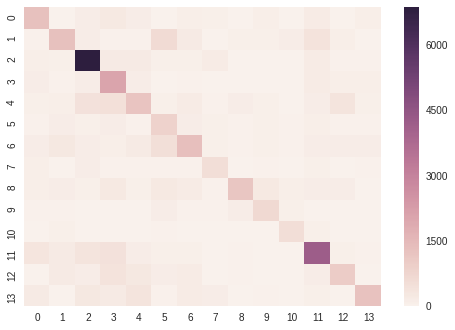

In [0]:
scores = model.evaluate(cluster_1_padded_sents_test, cluster_1_test_label, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))
# Classification Report (Precision, Recall and F1-Score)


y_true = np.argmax(cluster_1_test_label, axis=1)
y_pred = np.argmax(model.predict(cluster_1_padded_sents_test),axis=1)
classificationReport = classification_report(y_true, y_pred)

print(classificationReport)

conf = confusion_matrix(y_true, y_pred)
seaborn.heatmap(conf)
print(confusion_matrix(y_true, y_pred))

## Cluster 2

### Assigning numbers to labels

In [0]:
num_label_cluster_2 = dict(list(enumerate(sorted(set(cluster_2_label)))))
num_label_cluster_2


{0: 'agriculture',
 1: 'audiovisual_and_media',
 2: 'budget',
 3: 'consumers',
 4: 'culture',
 5: 'customs',
 6: 'education_training_youth',
 7: 'employment_and_social_policy',
 8: 'enlargement',
 9: 'environment',
 10: 'food_safety',
 11: 'information_society',
 12: 'institutional_affairs',
 13: 'internal_market',
 14: 'justice_freedom_security',
 15: 'public_health',
 16: 'regional_policy',
 17: 'transport'}

### Tain sentence preparation

In [0]:
# Cluster 2 train data, sentence conversion
cluster_2_sent_train = []  # List to store the sentence
cluster_2_labels_train = [] # List to store the label(alpha)
cluster_2_label_num_train = []


for second_data, second_label in zip(cluster_2_data, cluster_2_label):
    # start chunking the text into 30 words with 10 word slide
    slides = slidingWindow(second_data.split(' '),30,10)
        
    for key,value in num_label_cluster_2.items():
        if value == second_label:
            num = key
    
    
    for slide in slides:
        cluster_2_sent_train.append(' '.join(slide).lower())
        cluster_2_labels_train.append(second_label)
        cluster_2_label_num_train.append(num)
        
# Cluster 2 test data        
cluster_2_sent_test = []  # List to store the sentence
cluster_2_labels_test = [] # List to store the label(alpha)
cluster_2_label_num_test = []


for second_data, second_label in zip(cluster_2_data_test, cluster_2_label_test):
    # start chunking the text into 30 words with 10 word slide
    slides = slidingWindow(second_data.split(' '),30,10)
        
    for key,value in num_label_cluster_2.items():
        if value == second_label:
            num = key
    
    
    for slide in slides:
        cluster_2_sent_test.append(' '.join(slide).lower())
        cluster_2_labels_test.append(second_label)
        cluster_2_label_num_test.append(num)

In [0]:
len(cluster_2_sent_train)

202900

### Tokenizing train sentences & one hot encoding train test labels

In [0]:
# tokenizing cluster 2 sents
tokenizer_cls2 = Tokenizer()
tokenizer_cls2.fit_on_texts(cluster_2_data)
cluster_2_train_sequences = tokenizer_cls2.texts_to_sequences(cluster_2_sent_train)
cluster_2_test_sequences = tokenizer_cls2.texts_to_sequences(cluster_2_sent_test)

# padding the sentences
cluster_2_padded_sents = keras.preprocessing.sequence.pad_sequences(cluster_2_train_sequences, maxlen=30, padding='post')

# checking vocab size
word_index_cls2 = tokenizer_cls2.word_index
vocab_size_cls2 = len(word_index_cls2)+1
onehot_encoder = OneHotEncoder(sparse=False)

onehot_encoder.fit(np.reshape(cluster_2_label_num_train,(-1,1)))

cluster_2_train_label = onehot_encoder.transform(np.reshape(cluster_2_label_num_train,(-1,1)))
cluster_2_test_label = onehot_encoder.transform(np.reshape(cluster_2_label_num_test,(-1,1)))


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
len(cluster_2_train_sequences), len(cluster_2_train_label)

(202900, 202900)

In [0]:
cluster_2_padded_sents_test = keras.preprocessing.sequence.pad_sequences(cluster_2_test_sequences, maxlen=30, padding='post')

In [0]:
cluster_2_train_label[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0.])

### Embedding Matrix creation

In [0]:
# converting embedding matrix into a form that can be used in keras embedding layer
embeddings_index_cls2 = {}

for i, line in enumerate(en_de):
    if i == 0:
        pass
    else:
        try:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index_cls2[word] = coefs
        except ValueError:
            print('Value error: {}'.format(values[1:5]))

# preparing embedding matrix for cluster 2
embedding_matrix_cls2 = np.zeros((len(word_index_cls2) + 1, 300))
for word, i in word_index_cls2.items():
    embedding_vector = embeddings_index_cls2.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_cls2[i] = embedding_vector

Value error: ['·', '-0.116043', '-0.0278416', '0.0375914']
Value error: ['—', '-0.000894651', '0.0377289', '-0.0714999']
Value error: ['gebäude', '-0.0360703', '-0.0850809', '-0.0597942']
Value error: ['waldfläche', '-0.0314779', '-0.0465583', '-0.0163933']
Value error: ['verkehrsfläche', '-0.0356581', '-0.0029205', '0.0181392']
Value error: ['erholungsfläche', '-0.0368387', '-0.0377135', '0.00746337']
Value error: ['landwirtschaftsfläche', '-0.0263421', '-0.046624', '-0.0177181']
Value error: ['sonstige_flächen', '-0.0559894', '-0.0219282', '-0.000380597']
Value error: ['gesamtfläche', '-0.0660608', '-0.0324034', '0.0221355']
Value error: ['wasserfläche', '-0.0588425', '-0.0477398', '-0.0339936']
Value error: ['•', '-0.0626246', '-0.0190532', '-0.0432283']


In [0]:
from collections import Counter
class_weights_cls2 = dict()

max_value = max(Counter(cluster_2_labels_train).values())

for keys, values in Counter(cluster_2_labels_train).items():
    for _keys, _values in num_label_cluster_2.items():
        if keys == _values:
            class_weights_cls2[_keys] = (max_value/ values)

In [0]:
class_weights_cls2

{0: 1.9686444766039557,
 1: 14.531750741839762,
 2: 9.625,
 3: 2.278403275332651,
 4: 11.02972972972973,
 5: 4.605228512318977,
 6: 1.9918652891889694,
 7: 1.3342414995640801,
 8: 2.558888076079005,
 9: 1.8271770763375867,
 10: 2.1573568281938327,
 11: 1.4357080035180299,
 12: 1.924394844388557,
 13: 1.1529334212261042,
 14: 1.0,
 15: 5.3556430446194225,
 16: 2.8077055383556933,
 17: 1.7258246405413025}

In [0]:
# Create sequential model_cls2
model_cls2 = Sequential()
model_cls2.add(emb(vocab_size_cls2, 300, weights=[embedding_matrix_cls2], input_length=30, trainable=True))   
model_cls2.add(Bidirectional(LSTM(40, activation='tanh',return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.5))))# LSTM layer 
model_cls2.add(keras.layers.Dropout(0.5))
model_cls2.add(Bidirectional(LSTM(40, activation='tanh',return_sequences=False, kernel_regularizer=keras.regularizers.l2(0.1))))
model_cls2.add(keras.layers.Dropout(0.5))
model_cls2.add(Dense(18, activation='softmax'))
model_cls2.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics=['accuracy'])
print(model_cls2.summary())
model_cls2.fit(cluster_2_padded_sents, cluster_2_train_label, validation_data=(cluster_2_padded_sents_test,cluster_2_test_label), epochs=50, batch_size=512, 
          verbose=1, callbacks=[reduce_rate,early_stop])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 300)           17940600  
_________________________________________________________________
bidirectional_5 (Bidirection (None, 30, 80)            109120    
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 80)            0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 80)                38720     
_________________________________________________________________
dropout_6 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 18)                1458      
Total params: 18,089,898
Trainable params: 18,089,898
Non-trainable params: 0
________________________________________________________________

### Evaluation


84135/84135 [==============================] - 70s 835us/step
Accuracy: 37.52%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.58      0.38      0.46      5639
           1       0.00      0.00      0.00      1071
           2       0.00      0.00      0.00      1386
           3       0.40      0.27      0.32      4628
           4       0.00      0.00      0.00       958
           5       0.00      0.00      0.00      1410
           6       0.30      0.50      0.38      3700
           7       0.24      0.51      0.32      7930
           8       0.21      0.44      0.29      2082
           9       0.30      0.36      0.33      5774
          10       0.51      0.51      0.51      3819
          11       0.59      0.43      0.50      8927
          12       0.27      0.32      0.29      6141
          13       0.46      0.40      0.43     10060
          14       0.63      0.52      0.57     10433
          15       0.00      0.00      0.00      2718
          16       0.31      0.22      0.26      3151
          17       0.23    

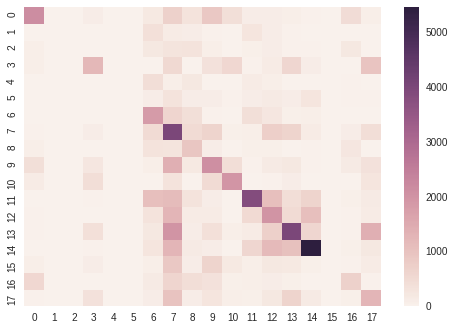

In [0]:
# Testing the data
model_cls2.save('my_method_cluster_2_model_FB_MUSE_trainableTrue.h5')  # creates a HDF5 file 'my_model.h5'

#cluster_2_test_sequences = tokenizer_cls2.texts_to_sequences(cluster_2_sent_test)
cluster_2_padded_sents_test = keras.preprocessing.sequence.pad_sequences(cluster_2_test_sequences, maxlen=30, padding='post')

scores_cls2 = model_cls2.evaluate(cluster_2_padded_sents_test, cluster_2_test_label, verbose=1)
print("Accuracy: %.2f%%" % (scores_cls2[1]*100))

y_true = np.argmax(cluster_2_test_label, axis=1)
y_pred = np.argmax(model_cls2.predict(cluster_2_padded_sents_test),axis=1)
classificationReport_cls2 = classification_report(y_true, y_pred)

print(classificationReport_cls2)


conf_cls2 = confusion_matrix(y_true, y_pred)
seaborn.heatmap(conf_cls2)
print(confusion_matrix(y_true, y_pred))

In [0]:
# Cluster 1 test data, sentence conversion
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

doc_id_pred = []
file_name_pred = []
multi_label_pred = []
pred_one_hot_encoded = []
label_one_hot_encoded = []
prd_for_doc = []

original_label = []
predicted_label = []

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from collections import Counter 


counter = 0
for first_data, first_label, _doc_id, _multi, _file_name in zip(cluster_2_data_test, cluster_2_label_test, 
                                   cluster_2_doc_id_test,cluster_2_multilabel_test,
                                   cluster_2_file_name_test ):
    
    ## TMP LIST for each doc
    sent_pred = []
    
    # start chunking the text into 30 words with 10 word slide
    slides = slidingWindow(first_data.split(' '),30,10)
        
    for key,value in num_label_cluster_2.items():
        if value == first_label:
            num = key
    
    doc_sent = []
    for slide in slides:
        
        a = ' '.join(slide).lower()
        
        doc_sent.append(a)
        
    # we have the slide here, create the sequence from text to numbers
    text_sequence = tokenizer_cls2.texts_to_sequences(doc_sent)

    # pad it to make flat 30 lenght
    text_padded = keras.preprocessing.sequence.pad_sequences(text_sequence, maxlen=30, padding='post')

    # Convert the label for this into one hot encoding
    label_one_hot = onehot_encoder.fit_transform(np.reshape(num,(1,-1)))

    # predict the label
    sent_pred.append(model_cls2.predict(text_padded))        
    

 
    nor_data = []
    for predc in sent_pred:
        transformer2 = Normalizer().fit(predc)
        nor_data.append(transformer2.transform(predc))    
        
    sent = np.zeros(18)
    for sen in nor_data:
        for i in range(len(sen)):
            sent += sen[i]
    
    predicted_label.append(np.argmax(sent, axis=0))
    original_label.append(num)
    
   
    label_one_hot_encoded.append(num)
    doc_id_pred.append(_doc_id)
    file_name_pred.append(_file_name)
    multi_label_pred.append(_multi)

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy_score(original_label, predicted_label)

0.6810810810810811

In [0]:
confusion_matrix(original_label, predicted_label)

array([[ 44,   0,   0,   1,   0,   0,   0,   1,   2,   6,   2,   2,   1,
          1,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   8,   1,   0,   0,   0,   3,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   1,   5,  10,   0,   0,   0,   0,
          0,   0,   0,   4,   0],
       [  2,   0,   0,  33,   0,   0,   0,   4,   0,   3,   5,   0,   0,
          8,   2,   0,   0,  17],
       [  0,   0,   0,   0,   0,   0,  11,   0,   1,   0,   0,   2,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   9,   0,   1,   0,   0,   0,
          2,   4,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  36,   5,   0,   0,   0,   3,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 107,   0,   0,   0,   0,   2,
          5,   0,   0,   0,   0],
       [  2,   0,   0,   0,   0,   0,   0,   0,  24,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  1,   0,   0,   2,   0,   0,

In [0]:
print(classification_report(original_label, predicted_label))

              precision    recall  f1-score   support

           0       0.79      0.73      0.76        60
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00        20
           3       0.75      0.45      0.56        74
           4       0.00      0.00      0.00        14
           5       0.00      0.00      0.00        16
           6       0.59      0.82      0.69        44
           7       0.45      0.94      0.61       114
           8       0.65      0.92      0.76        26
           9       0.62      0.66      0.64        80
          10       0.83      0.93      0.87        56
          11       0.83      0.84      0.84        96
          12       0.88      0.61      0.72        74
          13       0.78      0.68      0.73       150
          14       0.84      0.90      0.87       134
          15       0.00      0.00      0.00        40
          16       0.84      0.55      0.67        38
          17       0.48    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
